# ValidateDONutrients

Ben Roberts, 2022

Perform a validation of FVCOM-ICM water quality parameter output against observations compiled in a [database](https://github.com/bedaro/puget_sound_obsdata). This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model, and most of the plots are designed to mimic the ones Ecology uses in their Bounding Scenarios report.

## Parameters

 * `model_output_pattern`: A glob pattern of all the NetCDF files from the model run. Supports single or multiple NetCDF files, either in the ICMv4 format or Ecology's NetCDF format.
 * `run_name`: The name of this particular run, used to name the output files.
 * `start_date`: A plain text start date for when the model run began, which will be read with pd.Timestamp.
 * `end_date`: A plain text end date for when to stop validating the model output. This can just be set to None to use the end of the model output, but some ways to run the model let it continue running after boundary condition files have ended, and after that point this will corrupt the fit statistics.
 * `exclude_station_ids`: A sequence of station IDs to exclude from the validation, even though they fall within the model domain and had observations during the run period.
 * `stats_max_per_station`: To deal with automated buoys that have observations at a much higher frequency than human-collected data, any station with a total number of observations that exceeds this threshold will be subsampled randomly.

In [1]:
model_output_pattern = '/home/benr/wqmodels/ssm/ecology_bounding_outputs/2014_SSM4_WQ_Exist1_nodes.nc'
run_name = 'ecol_2014_SSM4_Exist1'
#model_output_pattern = '/home/benr/wqmodels/ssm/freshwater_iav_1/1_control/wqm/outputs/ssm_FVCOMICM_*.nc'
#run_name = 'freshwater_iav_control'
#start_date = '2012-01-01'
start_date = '2014-01-01'
end_date = None

# Don't validate with data from the Pacific coast (Willapa Bay, Grays Harbor)
#exclude_station_ids = ('WPA001','WPA003','WPA004','WPA006','WPA007',
#                       'WPA008','WPA102','WPA113','GYS004','GYS008',
#                       'GYS009','GYS015','GYS016')
exclude_station_ids = ()
# To exclude all the automated buoys add:
# 'CI','HC_HP','HC_DB','HC_NB','HC_TW','PointWilliams'
stats_max_per_station = 240
# Parameters for validating only part of the model grid
sectionsfile = '../SSM_Grid/sections.ini'
#limiting_sections = ['HoodCanalEntrance']
limiting_sections = []

import glob
import os
import os.path as path
import numpy as np
import pandas as pd
from configparser import ConfigParser
from netCDF4 import Dataset,MFDataset
import matplotlib.pyplot as plt
import contextily as cx
import db
from fvcom.grid import FvcomGrid
from fvcom.transect import Transect
from fvcom.control_volume import ControlVolume
import validation_util as vu

Open the model output, being smart enough to handle the case where there's only a single NetCDF file rather than multiple.

In [2]:
if len(glob.glob(model_output_pattern)) == 1:
    model_output = Dataset(model_output_pattern)
else:
    model_output = MFDataset(model_output_pattern)
model_output

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): IJK(160120), Time(8760)
    variables(dimensions): float32 Var_1(Time, IJK), float32 Var_2(Time, IJK), float32 Var_3(Time, IJK), float32 Var_4(Time, IJK), float32 Var_5(Time, IJK), float32 Var_6(Time, IJK), float32 Var_7(Time, IJK), float32 Var_8(Time, IJK), float32 Var_9(Time, IJK), float32 Var_10(Time, IJK), float32 Var_11(Time, IJK), float32 Var_12(Time, IJK), float32 Var_13(Time, IJK), float32 Var_14(Time, IJK), float32 Var_15(Time, IJK), float32 Var_16(Time, IJK), float32 Var_17(Time, IJK), float32 Var_18(Time, IJK), float32 Var_19(Time, IJK), float32 Var_20(Time, IJK), float32 Var_21(Time, IJK), float32 Var_22(Time, IJK), float32 Var_23(Time, IJK), float32 Var_24(Time, IJK), float32 Var_25(Time, IJK), float32 Var_26(Time, IJK), float32 Var_27(Time, IJK), float32 Var_28(Time, IJK), float32 Var_29(Time, IJK), float32 Var_30(Time, IJK), float32 Var_31(Time, IJK), float32 Var_

In [3]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)

In [4]:
if 'Var_1' in model_output.variables:
    grid = FvcomGrid.from_mesh('../SSM_Grid/ssm_grid.2dm')
    v = vu.EcolModelValidator(start_date, model_output, grid, end_date=end_date)
else:
    v = vu.ModelValidator(start_date, model_output, end_date=end_date)

display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2014-01-01 08:00:00+00:00 to 2015-01-01 08:00:00+00:00'

In [5]:
sections = ConfigParser()
sections.read(sectionsfile)
transects = []
for s in limiting_sections:
    waypoints = np.array(sections[s]['waypoints'].split(' ')).astype(int)
    assert len(waypoints) >= 2, f'Not enough waypoints defined for section {s}'
    if 'upesty' in sections[s] and sections[s]['upesty'] == 'l':
        waypoints = waypoints[::-1]
    transects.append(Transect.shortest(v.grid, waypoints))
if len(transects) > 0:
    cv = ControlVolume.from_transects(transects)
else:
    # For the entire model grid
    #cv = ControlVolume(grid=v.grid, nodes=set(np.arange(v.grid.m)+1), calc=True)
    cv = None

In [6]:
(o2_obs, nh4_obs, no23_only_obs, no3_obs, no2_obs, chla_obs), station_nodes = v.get_obsdata(
    ('o2','nh4','no23','no3','no2','chla'), cv=cv, exclude_stations=exclude_station_ids)

print(f'{len(o2_obs)} total DO measurements in {len(o2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(o2_obs.head())

# NH4: Fix units to match the model output
nh4_obs['value'] *= 14.01/1000
print(f'{len(nh4_obs)} total NH4 measurements in {len(nh4_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(nh4_obs.head())

print(f'{len(no23_only_obs)} total NO2+3 measurements in {len(no23_only_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no23_only_obs.head())

print(f'{len(no3_obs)} total NO3 measurements in {len(no3_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no3_obs.head())

print(f'{len(no2_obs)} total NO2 measurements in {len(no2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no2_obs.head())

print(f'{len(chla_obs)} total ChlA measurements in {len(chla_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(chla_obs.head())

679151 total DO measurements in 9224 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
94201762,2014-01-01 08:00:00+00:00,1.204,6.86,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977
94201763,2014-01-01 08:15:00+00:00,1.214,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977
94201764,2014-01-01 08:30:00+00:00,1.218,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977
94201765,2014-01-01 08:45:00+00:00,1.219,6.84,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977
94201766,2014-01-01 09:00:00+00:00,1.219,6.83,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977


2464 total NH4 measurements in 456 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
44089806,2014-01-07 02:03:44+00:00,30.0,0.000280,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,nh4,None,POINT (498150.066 5362613.548),3636
44089805,2014-01-07 02:03:44+00:00,80.0,0.000000,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,nh4,None,POINT (498150.066 5362613.548),3636
44089804,2014-01-07 02:03:44+00:00,140.5,0.000140,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,nh4,None,POINT (498150.066 5362613.548),3636
44089798,2014-01-07 02:10:08+00:00,1.5,0.004693,PTH005,448de0ac-f245-3f39-a21a-3f7624c793c6,nh4,None,POINT (517628.444 5325588.977),5308
44089797,2014-01-07 02:10:08+00:00,11.0,0.002662,PTH005,448de0ac-f245-3f39-a21a-3f7624c793c6,nh4,None,POINT (517628.444 5325588.977),5308


1113 total NO2+3 measurements in 0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
93999063,2014-01-21 16:43:00+00:00,54.50,31.977159,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999067,2014-01-21 16:45:00+00:00,24.70,33.119201,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999071,2014-01-21 16:45:00+00:00,34.60,32.476802,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999075,2014-01-21 16:46:00+00:00,14.70,32.619557,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999078,2014-01-21 16:47:00+00:00,0.96,33.119201,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312


3601 total NO3 measurements in 649 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
44074630,2014-01-07 02:03:44+00:00,30.0,27.74,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,no3,None,POINT (498150.066 5362613.548),3636
44074629,2014-01-07 02:03:44+00:00,80.0,27.83,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,no3,None,POINT (498150.066 5362613.548),3636
44074628,2014-01-07 02:03:44+00:00,140.5,28.01,SJF000,52f58555-0cce-3635-a6a9-209eea2dedfc,no3,None,POINT (498150.066 5362613.548),3636
44074622,2014-01-07 02:10:08+00:00,1.5,27.93,PTH005,448de0ac-f245-3f39-a21a-3f7624c793c6,no3,None,POINT (517628.444 5325588.977),5308
44074621,2014-01-07 02:10:08+00:00,11.0,28.09,PTH005,448de0ac-f245-3f39-a21a-3f7624c793c6,no3,None,POINT (517628.444 5325588.977),5308


717 total NO2 measurements in 82 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
54291157,2014-07-15 02:49:24+00:00,2.564358,0.20,nan_CAB1019,f63b5919-1e97-33f0-baa5-5ebd6b326b78,no2,None,POINT (540987.557 5283046.303),9136
54291156,2014-07-15 02:49:24+00:00,6.526853,0.20,nan_CAB1019,f63b5919-1e97-33f0-baa5-5ebd6b326b78,no2,None,POINT (540987.557 5283046.303),9136
54291155,2014-07-15 02:49:24+00:00,11.511593,0.27,nan_CAB1019,f63b5919-1e97-33f0-baa5-5ebd6b326b78,no2,None,POINT (540987.557 5283046.303),9136
54291154,2014-07-15 02:49:24+00:00,20.375148,0.33,nan_CAB1019,f63b5919-1e97-33f0-baa5-5ebd6b326b78,no2,None,POINT (540987.557 5283046.303),9136
54291153,2014-07-15 02:49:24+00:00,31.451323,0.37,nan_CAB1019,f63b5919-1e97-33f0-baa5-5ebd6b326b78,no2,None,POINT (540987.557 5283046.303),9136


273250 total ChlA measurements in 3209 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
94329338,2014-01-01 08:00:00+00:00,1.204,2.7,PointWilliams,None,chla,Point Williams,POINT (544695.723 5265030.897),10977
94329339,2014-01-01 08:15:00+00:00,1.214,2.2,PointWilliams,None,chla,Point Williams,POINT (544695.723 5265030.897),10977
94329340,2014-01-01 08:30:00+00:00,1.218,2.5,PointWilliams,None,chla,Point Williams,POINT (544695.723 5265030.897),10977
94329341,2014-01-01 08:45:00+00:00,1.219,1.8,PointWilliams,None,chla,Point Williams,POINT (544695.723 5265030.897),10977
94329342,2014-01-01 09:00:00+00:00,1.219,1.1,PointWilliams,None,chla,Point Williams,POINT (544695.723 5265030.897),10977


In [7]:
station_nodes.head()

,description,geom,node
name,,,
dfo1_2,None,POINT (315563.061 5383231.022),503
dfo1_3,None,POINT (278774.145 5387394.121),136
dfo1_38,None,POINT (481733.315 5384614.216),3792
dfo1_41,None,POINT (467946.14 5430846.332),6075
dfo1_46,None,POINT (482518.501 5396042.588),4403


Combine NO3 and NO2 measurements, then add them to the no23_obs DataFrame

NB: This assumes there is a matching NO3 measurement for every NO2 measurement. That's dangerous, as if any NO3 measurements are missing, I'm not sure how the addition of the Series is handled. It should result in a NaN that needs to be dropped.

In [8]:
common_idx = ['datetime','location_id','depth']
combined_no23 = no3_obs.set_index(common_idx).merge(no2_obs.set_index(common_idx)[['value']], how='left', left_index=True, right_index=True)
combined_no23['value'] = np.where(combined_no23['value_y'].isna(), combined_no23['value_x'], combined_no23['value_x'] + combined_no23['value_y'])
del combined_no23['value_x']
del combined_no23['value_y']
combined_no23.reset_index(inplace=True)
combined_no23['parameter_id'] = 'no23'
combined_no23.head()

,datetime,location_id,depth,cast_id,parameter_id,description,geom,node,value
0,2014-01-07 02:03:44+00:00,SJF000,30.0,52f58555-0cce-3635-a6a9-209eea2dedfc,no23,None,POINT (498150.066 5362613.548),3636,27.74
1,2014-01-07 02:03:44+00:00,SJF000,80.0,52f58555-0cce-3635-a6a9-209eea2dedfc,no23,None,POINT (498150.066 5362613.548),3636,27.83
2,2014-01-07 02:03:44+00:00,SJF000,140.5,52f58555-0cce-3635-a6a9-209eea2dedfc,no23,None,POINT (498150.066 5362613.548),3636,28.01
3,2014-01-07 02:10:08+00:00,PTH005,1.5,448de0ac-f245-3f39-a21a-3f7624c793c6,no23,None,POINT (517628.444 5325588.977),5308,27.93
4,2014-01-07 02:10:08+00:00,PTH005,11.0,448de0ac-f245-3f39-a21a-3f7624c793c6,no23,None,POINT (517628.444 5325588.977),5308,28.09


In [9]:
no23_obs = pd.concat([no23_only_obs, combined_no23])
# Fix units to match the model output
no23_obs['value'] *= 14.01/1000
print(f'{len(no23_obs)} total NO2+NO3 measurements')
print(f'{len(no23_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no23_obs.head()

4714 total NO2+NO3 measurements
649 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
93999063,2014-01-21 16:43:00+00:00,54.50,0.448,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999067,2014-01-21 16:45:00+00:00,24.70,0.464,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999071,2014-01-21 16:45:00+00:00,34.60,0.455,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999075,2014-01-21 16:46:00+00:00,14.70,0.457,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312
93999078,2014-01-21 16:47:00+00:00,0.96,0.464,CK200P,None,no23,CARKEEK PARK OUTFALL,POINT (545909.471 5284544.674),9312


In [10]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in o2_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(o2_obs.loc[o2_obs['cast_id'].isna()]))

o2_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
o2_validation_df.to_csv(out_file("o2_validation.csv"), index=False)
o2_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,3.305643,2,11.839574,9.53318
1,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,6.928796,3,8.039760,7.24481
2,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,11.394173,4,6.528665,5.70649
3,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,16.561200,5,6.093704,5.64330
4,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,22.343649,6,5.650647,5.60034
...,...,...,...,...,...,...,...,...,...
86406,LSEP01,10186,NaN,2014-10-06 19:28:57+00:00,6683,1.000000,1,6.280000,7.80711
86407,MSJN02,11783,NaN,2014-10-21 19:29:08+00:00,7043,1.000000,1,7.601400,7.91888
86408,LSNT01,10975,NaN,2014-11-04 19:58:55+00:00,7380,0.500000,1,8.601000,8.75449
86409,LSNT01,10975,NaN,2014-11-04 19:59:01+00:00,7380,1.000000,1,6.725400,8.75449


In [11]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in nh4_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(nh4_obs.loc[nh4_obs['cast_id'].isna()]))

nh4_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
nh4_validation_df.to_csv(out_file("nh4_validation.csv"), index=False)
nh4_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,CSE001,15302,01c6dd15-8075-3d60-99d9-57c81a7e3642,2014-01-15 05:02:56+00:00,334,2.518539,2,0.002970,0.018145
1,CSE001,15302,01c6dd15-8075-3d60-99d9-57c81a7e3642,2014-01-15 05:02:56+00:00,334,5.278987,3,0.002288,0.018488
2,CSE001,15302,01c6dd15-8075-3d60-99d9-57c81a7e3642,2014-01-15 05:02:56+00:00,334,8.681117,4,0.001447,0.018927
3,CSE001,15302,01c6dd15-8075-3d60-99d9-57c81a7e3642,2014-01-15 05:02:56+00:00,334,12.617827,5,0.001550,0.019419
4,CSE001,15302,01c6dd15-8075-3d60-99d9-57c81a7e3642,2014-01-15 05:02:56+00:00,334,17.023422,6,0.002273,0.019485
...,...,...,...,...,...,...,...,...,...
3351,LTED04,10635,NaN,2014-12-15 20:18:00+00:00,8364,24.300000,5,0.002500,0.017341
3352,LSEP01,10186,NaN,2014-12-16 16:51:00+00:00,8384,99.600000,8,0.010800,0.047916
3353,LSEP01,10186,NaN,2014-12-16 16:57:00+00:00,8384,1.100000,1,0.002300,0.016554
3354,LSKQ06,10630,NaN,2014-12-16 17:25:00+00:00,8385,1.000000,1,0.004200,0.017876


In [12]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in no23_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(no23_obs.loc[no23_obs['cast_id'].isna()]))

no23_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
no23_validation_df.to_csv(out_file("no23_validation.csv"), index=False)
no23_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,dfo1_3302,381,01c4a6fe-ea48-3ca7-a1d1-228338cf3d97,2014-09-09 20:43:50+00:00,6037,11.824326,2,0.262227,0.283567
1,dfo1_3302,381,01c4a6fe-ea48-3ca7-a1d1-228338cf3d97,2014-09-09 20:43:50+00:00,6037,24.784393,3,0.366273,0.332508
2,dfo1_3302,381,01c4a6fe-ea48-3ca7-a1d1-228338cf3d97,2014-09-09 20:43:50+00:00,6037,40.757105,4,0.397087,0.368052
3,dfo1_3302,381,01c4a6fe-ea48-3ca7-a1d1-228338cf3d97,2014-09-09 20:43:50+00:00,6037,59.239626,5,0.374191,0.398988
4,dfo1_3302,381,01c4a6fe-ea48-3ca7-a1d1-228338cf3d97,2014-09-09 20:43:50+00:00,6037,79.923520,6,0.370120,0.415665
...,...,...,...,...,...,...,...,...,...
5210,NSEX01,12735,NaN,2014-12-16 20:39:00+00:00,8388,34.800000,5,0.401000,0.409840
5211,NSEX01,12735,NaN,2014-12-16 20:40:00+00:00,8388,24.900000,4,0.400000,0.409765
5212,NSEX01,12735,NaN,2014-12-16 20:41:00+00:00,8388,14.900000,3,0.399000,0.409922
5213,NSEX01,12735,NaN,2014-12-16 20:42:00+00:00,8388,0.830000,1,0.397000,0.404329


In [13]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in chla_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(chla_obs.loc[chla_obs['cast_id'].isna()]))

chla_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
chla_validation_df.to_csv(out_file("chla_validation.csv"), index=False)
chla_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_HP,13095,000c91c5-8bcc-4a68-8d70-9ed15d20b122,2014-05-23 16:20:24.749998+00:00,3417,4.465845,2,2.802323,16.682981
1,HC_HP,13095,000c91c5-8bcc-4a68-8d70-9ed15d20b122,2014-05-23 16:20:24.749998+00:00,3417,9.360641,3,4.251628,7.138348
2,HC_HP,13095,000c91c5-8bcc-4a68-8d70-9ed15d20b122,2014-05-23 16:20:24.749998+00:00,3417,15.393261,4,4.519142,2.449842
3,HC_HP,13095,000c91c5-8bcc-4a68-8d70-9ed15d20b122,2014-05-23 16:20:24.749998+00:00,3417,22.373792,5,3.058273,0.980446
4,HC_HP,13095,000c91c5-8bcc-4a68-8d70-9ed15d20b122,2014-05-23 16:20:24.749998+00:00,3417,30.185745,6,2.656637,0.395530
...,...,...,...,...,...,...,...,...,...
41083,LSEP01,10186,NaN,2014-10-06 19:28:57+00:00,6683,1.000000,1,3.246200,13.183911
41084,MSJN02,11783,NaN,2014-10-21 19:29:08+00:00,7043,1.000000,1,12.863000,3.826022
41085,LSNT01,10975,NaN,2014-11-04 19:58:55+00:00,7380,0.500000,1,0.667800,1.091523
41086,LSNT01,10975,NaN,2014-11-04 19:59:01+00:00,7380,1.000000,1,1.429000,1.091523


,Metric,R,RMSE,NSE,Bias,n
0,Dissolved Oxygen,0.801001,1.354171,0.587003,-0.420588,16202
1,Ammonia,0.355368,0.018078,-0.006729,0.003352,3356
2,Total Nitrate+Nitrite,0.804866,0.074898,0.595257,0.015726,5215
3,Chlorophyll-A,0.399428,8.673631,-0.350735,1.395500,7657


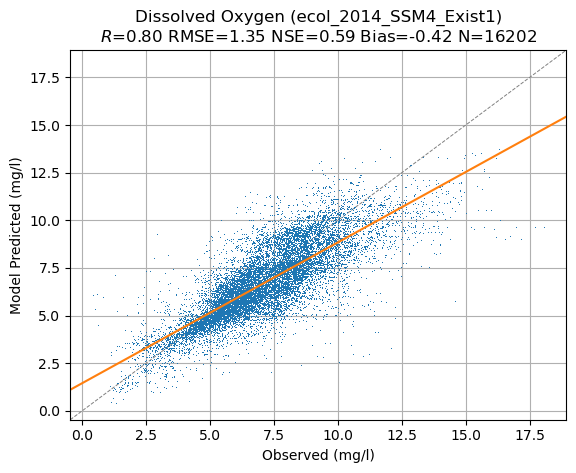

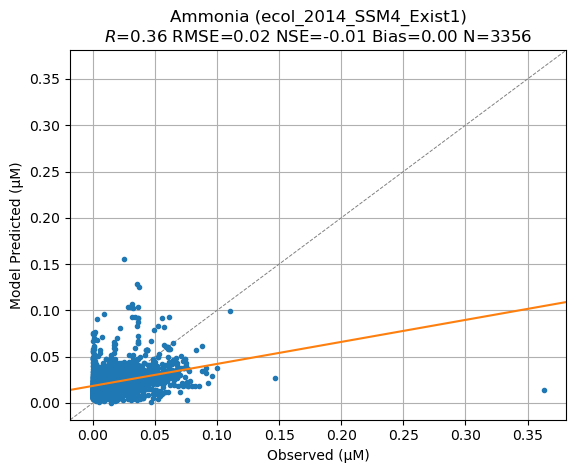

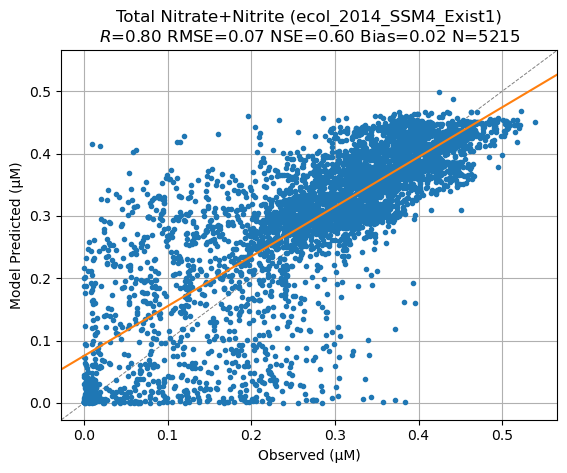

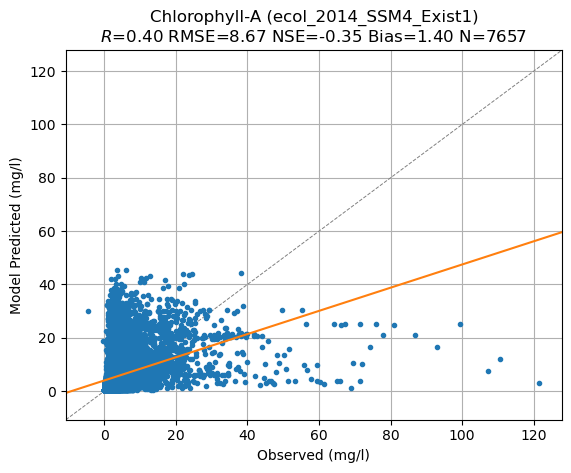

In [14]:
cum_stats = []
for pfx, label, data, unit in zip(("o2","nh4","no23","chla"),
        ("Dissolved Oxygen","Ammonia","Total Nitrate+Nitrite","Chlorophyll-A"),
        (o2_validation_df,nh4_validation_df,no23_validation_df,chla_validation_df),
        ("mg/l","\u03BCM","\u03BCM","mg/l")):
    if data.empty:
        continue
    # Downsample any stations with a high number of total observations
    # (ie automated buoys), otherwise a small number of stations will skew
    # the results heavily toward just showing how well the model represents
    # a handful of locations
    sampled = []
    for s,group in data.groupby('location'):
        if len(group) > stats_max_per_station:
            samp = group.sample(n=stats_max_per_station)
        else:
            samp = group
        sampled.append(samp)
    sampled_df = pd.concat(sampled)
    fit, rsq, rmse, nse, bias, n = vu.run_stats(sampled_df["observed"], sampled_df["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, sampled_df['observed'], sampled_df['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, nse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","NSE","Bias","n"]))

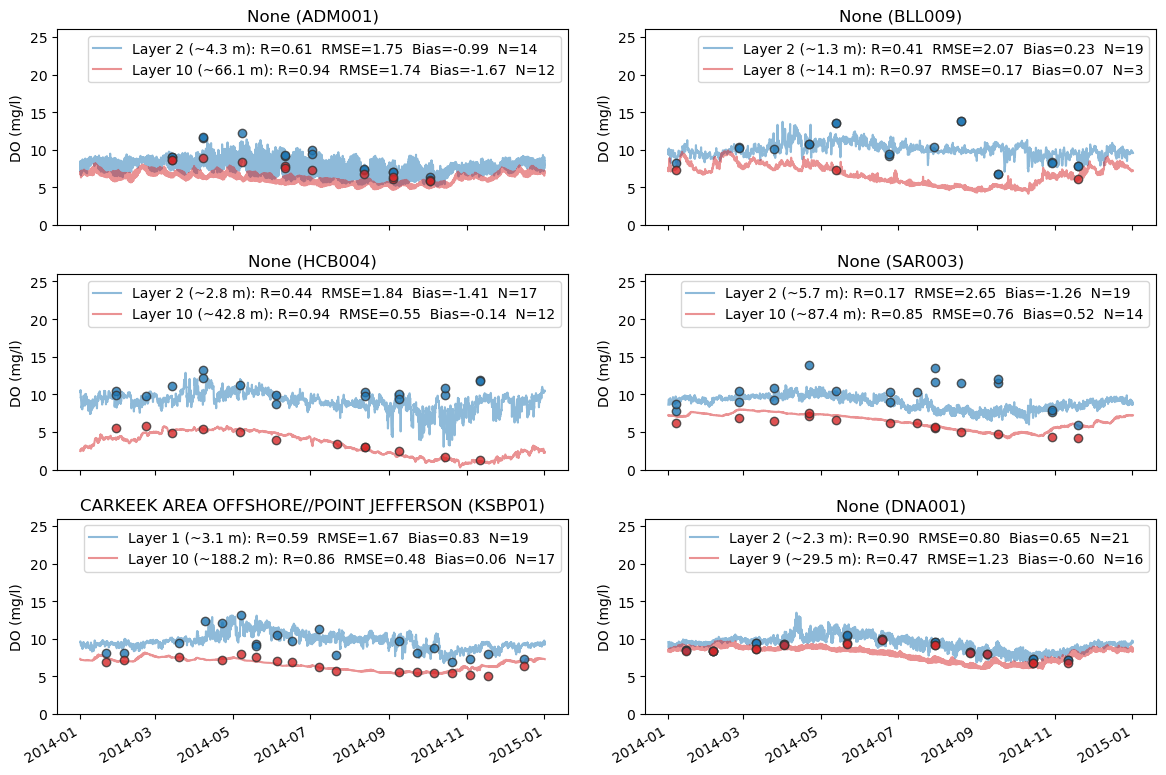

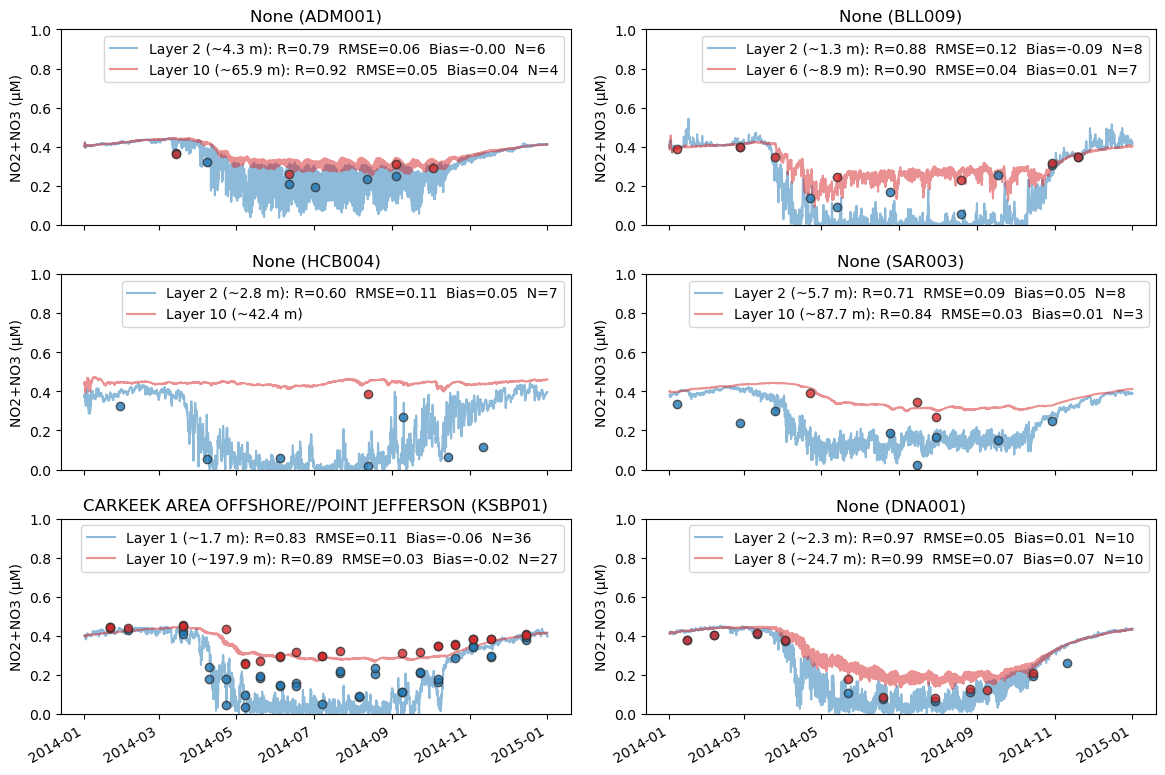

In [15]:
# Build time series plots of DO and nutrients that
# mimic fig 21 in the Bounding Scenarios report

plot_stations = ["ADM001","BLL009","HCB004","SAR003","KSBP01","DNA001"]
colors = ('tab:blue','tab:red')
datasets = {
    "o2": {
        "data": o2_validation_df,
        "obsdata": o2_obs,
        "ylabel": "DO (mg/l)",
        "ybound": (0, 26),
        "xbound": (0, 26)
    },
    "no23": {
        "data": no23_validation_df,
        "obsdata": no23_obs,
        "ylabel": "NO2+NO3 (\u03BCM)",
        "ybound": (0, 1),
        "xbound": (0, 1)
    }
}

for key,vals in datasets.items():
    data = vals['data']
    if data.empty:
        continue
    fig, axs = plt.subplots(3,2, figsize=(12,9))
    for ax,s in zip(np.array(axs).flatten(), plot_stations):
        zs = vu.tsplot_zs(v, data.loc[data['location'] == s])
        for z,color in zip(zs, colors):
            selector = (data["location"] == s) & (data["sigma"] == z)
            observed = data.loc[selector]
            if len(observed) == 0:
                # No observations at this station!
                node = station_nodes.loc[s, 'node']
                lbl = f'Layer {z}'
            else:
                havg = observed['depth'].mean()
                lbl = f'Layer {z} (~{havg:.1f} m)'
                node = observed.iloc[0]['node']
                ax.plot(observed["datetime"], observed["observed"], "o",
                        color=color, alpha=0.8, markeredgecolor='.2', zorder=2)

                if len(observed) > 2:
                    fit, r, rmse, ns, bias, n = vu.run_stats(observed["observed"],
                                                         observed["model"])
                    lbl += ": R=%.2f  RMSE=%.2f  Bias=%.2f  N=%d" % (r, rmse, bias, n)

            # Extract the full time series from the output file
            modeled_y = v.get_model_match(key, slice(None), z-1,node-1)
            modeled_x = v.get_times()
            ax.plot(modeled_x, modeled_y, color=color, alpha=0.5, label=lbl, zorder=1)
        ax.set(title=f'{station_nodes.loc[s, "description"]} ({s})',
               ylabel=vals['ylabel'], ybound=vals['ybound'])
        ax.legend()
    plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(out_file(f'{key}_validation_station_ts.png'))

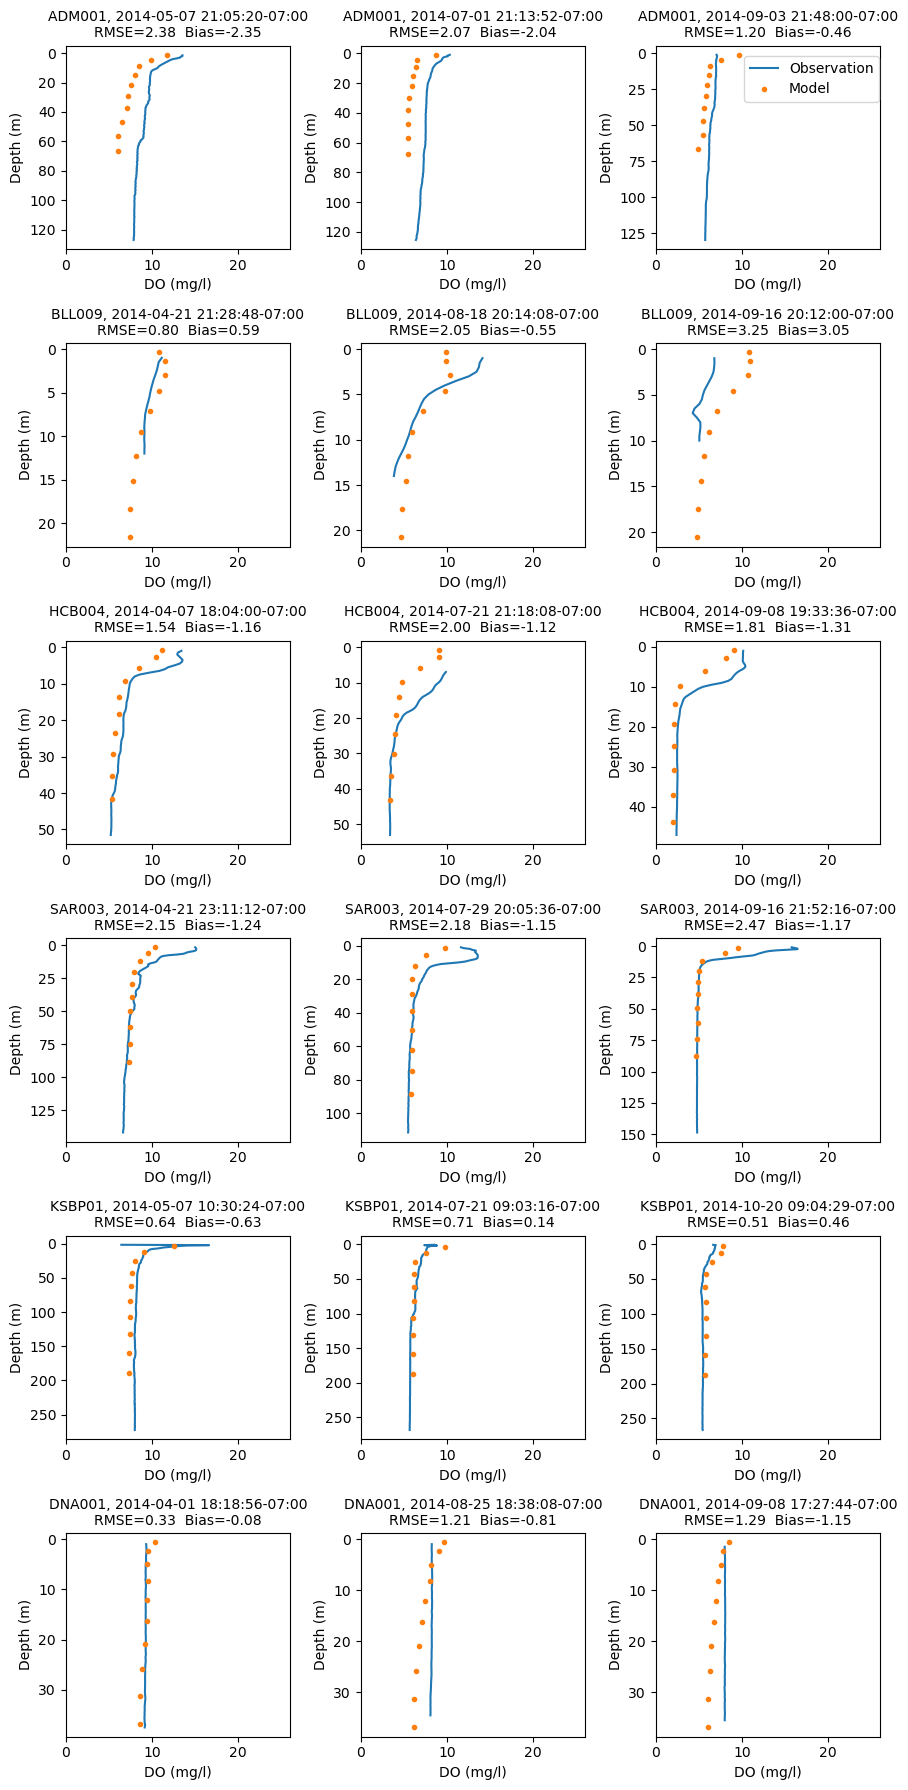

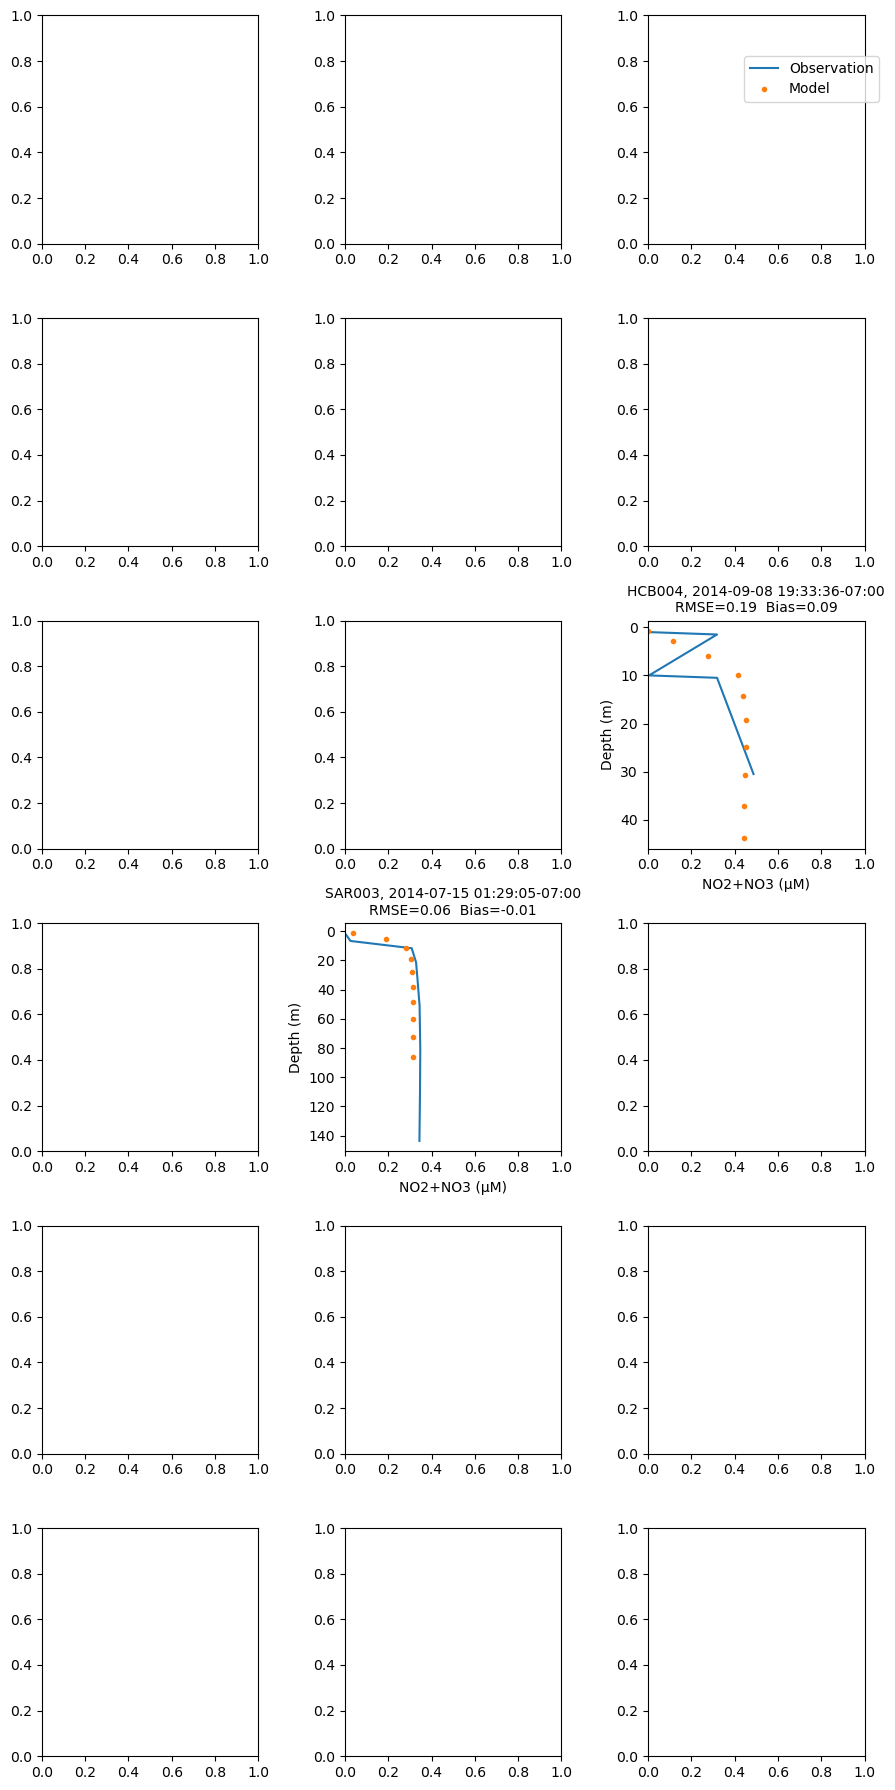

In [16]:
# Ranges of months to generate profile plots for
month_ranges = (
    (4, 5),
    (7, 8),
    (9, 10)
)
rand_seed = 4

for key,vals in datasets.items():
    fig, axs = plt.subplots(len(plot_stations), len(month_ranges),
                            figsize=(3*len(month_ranges), 3 * len(plot_stations)))
    d = vals['data']
    od = vals['obsdata']
    # Keep track of whether or not we found anything to plot among the ranges
    # given from this dataset
    plotted = False
    for i,mr in enumerate(month_ranges):
        for j,s in enumerate(plot_stations):
            ax = axs[j,i]
            # Pick a "random" cast from the time range, using a constant seed for reproducibility
            cast_candidates = od.loc[
                (od['datetime'].dt.month >= mr[0]) & (od['datetime'].dt.month <= mr[-1]) \
                & (od['location_id'] == s) & ~od['cast_id'].isna(), 'cast_id'
            ]
            if len(cast_candidates) == 0:
                continue
            obs_cast_id = None
            cands = cast_candidates.sample(min(10, len(cast_candidates)), random_state=rand_seed).to_list()
            cands.reverse()
            while obs_cast_id is None:
                if not len(cands):
                    break
                obs_cast_id = cands.pop()
                if len(od.loc[od['cast_id'] == obs_cast_id]) < 5:
                    obs_cast_id = None
            if obs_cast_id is None:
                # Couldn't find a suitable cast
                continue

            obs = od.loc[od['cast_id'] == obs_cast_id].sort_values(by='depth')
            lobs, = ax.plot(obs['value'], obs['depth'], label='Observation')
            cast_dt = obs['datetime'].iloc[0].tz_convert('US/Pacific')

            # Get model results that correspond to this cast_id. Use vals['data'] to fetch node and t,
            # retrieve all sigma layers, then recalculate matching depths using the same method as
            # process_cast
            node = obs['node'].iloc[0]
            cast_selector = d['cast_id'] == obs_cast_id
            t = d.loc[cast_selector, 't'].iloc[0]
            modeled_x = v.get_model_match(key, t, slice(None), node-1)
            modeled_y = ((v.grid.ncoord[2, node-1] + v._get_ssh(t, node-1))
                         * v.depthcoord.zz[:-1] * -1)
            lmodel, = ax.plot(modeled_x, modeled_y, '.', label='Model')
            
            fit, r, rmse, ns, bias, n = vu.run_stats(d.loc[cast_selector, "observed"],
                                                 d.loc[cast_selector, "model"])

            ax.set_title(f'{s}, {cast_dt}\nRMSE={rmse:.2f}  Bias={bias:.2f}', fontsize=10)
            ax.set(ylabel='Depth (m)', xlabel=vals['ylabel'], xbound=vals['xbound'])
            ax.set_ylim(ax.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
            plotted = True

    if plotted:
        fig.tight_layout()
        fig.legend((lobs, lmodel), ('Observation','Model'), loc='upper right', bbox_to_anchor=(0.99, 0.97))
        fig.savefig(out_file(f'{key}_validation_station_pr.png'))
    else:
        plt.close(fig)

DO skill over time

In [17]:
per_month = []
for name, group in o2_validation_df.groupby(o2_validation_df["datetime"].dt.date):
    fit, rsq, rmse, ns, bias, n = vu.run_stats(group['observed'], group['model'])
    per_month.append([name, rsq, rmse, bias, n])

per_month_stats = pd.DataFrame(per_month, columns=["Date","R","RMSE","Bias","n"])
per_month_stats.to_csv(out_file('o2_skill_per_month.csv'))
per_month_stats

,Date,R,RMSE,Bias,n
0,2014-01-01,0.970962,2.466039,2.317174,73
1,2014-01-02,0.936776,2.305572,2.196450,105
2,2014-01-03,0.941241,2.124606,2.001289,105
3,2014-01-04,0.926724,1.979242,1.850060,105
4,2014-01-05,0.932471,1.661417,1.548377,105
...,...,...,...,...,...
360,2014-12-27,0.528391,1.089701,1.004384,32
361,2014-12-28,0.001496,1.321429,1.149098,32
362,2014-12-29,0.108390,1.247799,0.991471,24
363,2014-12-30,0.697937,1.301077,1.019517,29


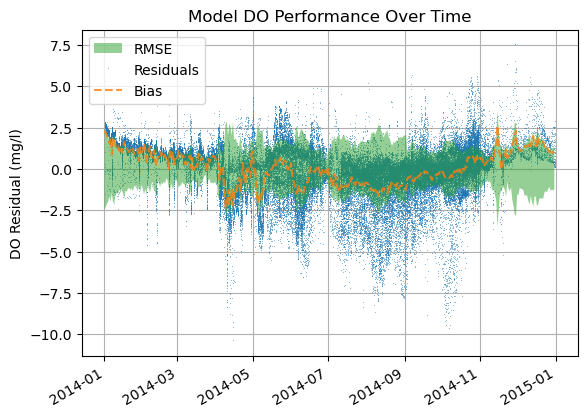

In [18]:
# Plot temperature residuals over time
o2_resids = o2_validation_df["model"] - o2_validation_df["observed"]
fig, ax = plt.subplots()
ax.fill_between(per_month_stats["Date"],
                per_month_stats["RMSE"],
                -per_month_stats["RMSE"],
                facecolor="tab:green", alpha=0.5, label="RMSE", zorder=4)
ax.plot(o2_validation_df["datetime"].to_numpy(), o2_resids, ",", label="Residuals", alpha=0.5)
ax.plot(per_month_stats["Date"].to_numpy(), per_month_stats["Bias"], "--", label="Bias", alpha=0.8, zorder=5)
ax.set(title="Model DO Performance Over Time", ylabel="DO Residual (mg/l)")
ax.grid()
ax.legend()
fig.autofmt_xdate()
fig.savefig(out_file("o2_skill_vs_t.png"))

/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:303: RuntimeWarning: divide by zero encountered in scalar divide
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:304: RuntimeWarning: divide by zero encountered in scalar divide
  scl = newlen/oldlen
/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/site-packages/numpy/polynomial/polyutils.py:372: RuntimeWarning: invalid value encountered in add
  return off + scl*x
/home/benr/src/ssm-analysis/validation/validation_util.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  np.sum((evaluation - simulations) ** 2, axis=0, dtype=np.float64)


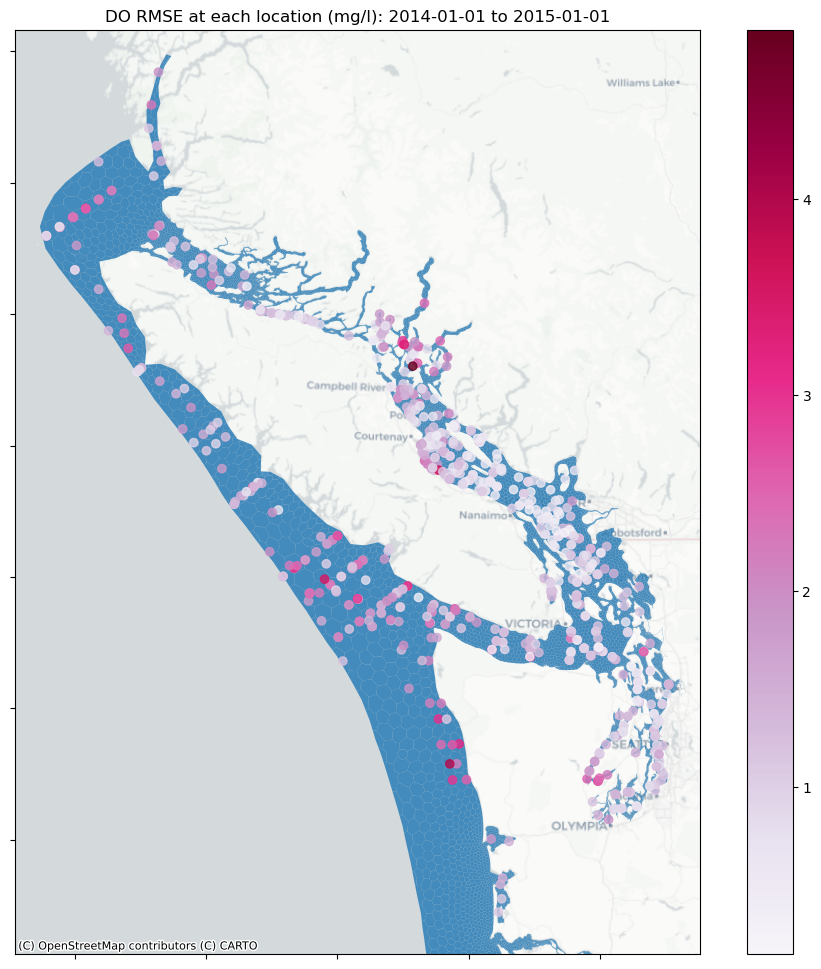

In [19]:
full_grid = v.grid.tces_gdf()
station_fits = station_nodes.copy()
station_fits['rmse'] = np.nan
for l,group in o2_validation_df.groupby('location'):
    fit, rsq, rmse, ns, bias, n = vu.run_stats(group['observed'], group['model'])
    station_fits.loc[l, 'rmse'] = rmse
fig, ax = plt.subplots(figsize=(12,12))
p = station_fits.plot(ax=ax, column='rmse', zorder=2, legend=True, cmap='PuRd', alpha=0.8)
# Save the axes boundaries so we can restore them after plotting the full model
# boundary
xmin, xmax, ymin, ymax = p.axis()
if False:
    # Zoom out a bit to make room for labels
    dx = (xmax - xmin) / 2
    dy = (ymax - ymin) / 2
    xmin -= 0.4 * dx
    xmax += 0.6 * dx
    #ymin -= 0.4 * dy
    #ymax += 0.4 * dy
    ax.set(xbound=(xmin, xmax), ybound=(ymin, ymax))
    from adjustText import adjust_text
    import matplotlib.patheffects as pe
    texts = station_fits.apply(
        lambda x: ax.annotate(x.name, xy=x['geom'].coords[0], ha='center', va='center',
                              path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.6)]
                             ), axis=1).to_list()
    adjust_text(texts, arrowprops=dict(arrowstyle='-'))
full_grid.plot(ax=ax, alpha=0.8, zorder=1)
ax.set(title=f'DO RMSE at each location (mg/l): {v.start_date.date()} to {v.end_date.date()}',
       ybound=(ymin, ymax), xbound=(xmin, xmax), xticklabels=(), yticklabels=())
cx.add_basemap(ax, crs=full_grid.crs, source=cx.providers.CartoDB.Positron)
if True:
    fig.savefig(out_file("o2_rmse_by_station.png"))